In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# =========================
# CONSTANTEN (Exercise 1)
# =========================
# Kies hier waarden die fysisch redelijk zijn, én botsingen goed laten zien.

BOX_SIZE_0 = 10.0   # grootte van de vierkante box (2D)
N = 40              # aantal deeltjes
V_0 = 2.0           # typische grootte beginsnelheid (in sim-eenheden)
RADIUS = 0.1        # straal van moleculen
DT = 0.01           # tijdstap

# Voor het koppelen aan echte eenheden later (Exercise 4):
# We interpreteren BOX_SIZE_0 als lengte in meters: L_unit = 1 m
L_unit = 1.0        # 1 sim-lengte = 1 meter
T_unit = 1.0        # 1 sim-tijd = 1 seconde
M_unit = 1.0e-26    # 1 sim-massa = 1e-26 kg (orde van grootte gasmolecuul)

k_B = 1.380649e-23  # Boltzmann-constante in J/K


In [3]:
# =========================
# PARTICLE CLASS EN BOTSNGEN
# =========================

class ParticleClass:
    def __init__(self, m, v, r, R):
        """
        Maakt een deeltje (constructor).
        m: massa (in sim-eenheden)
        v: 2D-snelheidsvector
        r: 2D-positievector
        R: straal
        """
        self.m = m
        self.v = np.array(v, dtype=float)
        self.r = np.array(r, dtype=float)
        self.R = R

    def update_position(self):
        """Verandert positie voor één tijdstap."""
        self.r += self.v * DT

    @property
    def momentum(self):
        return self.m * self.v

    @property
    def kin_energy(self):
        return 0.5 * self.m * np.dot(self.v, self.v)


def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """Geeft True als de deeltjes overlappen."""
    dx = p1.r[0] - p2.r[0]
    dy = p1.r[1] - p2.r[1]
    rr = p1.R + p2.R
    return dx**2 + dy**2 < rr**2


def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """
    Past snelheden aan uitgaande van overlap, elastische botsing in 2D.
    """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)

    # Als deeltjes van elkaar wegbeweren, geen botsing doorvoeren.
    if dot_product >= 0:
        return

    distance_squared = np.dot(delta_r, delta_r)

    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r


In [5]:
# =========================
# OUDE BOX-RANDVOORWAARDEN
# =========================

def box_collision(particle: ParticleClass):
    """Botsing met harde wanden (oude versie)."""
    if abs(particle.r[0]) + particle.R > BOX_SIZE_0 / 2:
        particle.v[0] = -particle.v[0]
        particle.r[0] = np.sign(particle.r[0]) * (BOX_SIZE_0/2 - particle.R)

    if abs(particle.r[1]) + particle.R > BOX_SIZE_0 / 2:
        particle.v[1] = -particle.v[1]
        particle.r[1] = np.sign(particle.r[1]) * (BOX_SIZE_0/2 - particle.R)


def create_particles(particles):
    """Leegmaken en opnieuw aanmaken van deeltjes in lijst."""
    particles.clear()
    for i in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(max(V_0**2 - vx**2, 0.0))
        pos = np.random.uniform(-BOX_SIZE_0/2 + RADIUS,
                                BOX_SIZE_0/2 - RADIUS, 2)
        particles.append(
            ParticleClass(m=1.0, v=[vx, vy], r=pos, R=RADIUS)
        )


def handle_collisions(particles):
    """Alle onderlinge botsingen afhandelen voor deeltjes in lijst."""
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])


def handle_walls_old(particles):
    """Botsing met wanden controleren voor alle deeltjes in lijst (oude versie)."""
    for p in particles:
        box_collision(p)


def take_time_step_old(particles):
    """
    Zet tijdstap voor een lijst deeltjes en verwerk alle botsingen
    onderling en met wanden (oude versie randvoorwaarden).
    """
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls_old(particles)


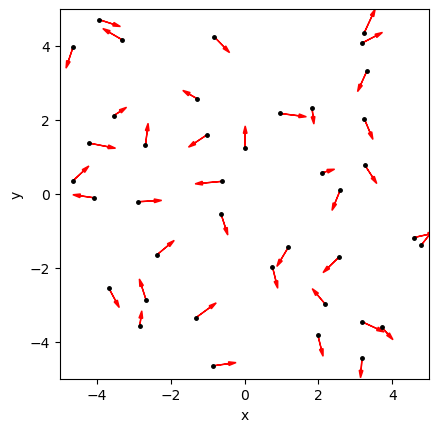

In [15]:
#Eerste eenvoudige simulatie-check (uit de tekst)

particles = []
create_particles(particles)

for i in range(100):
    take_time_step_old(particles)

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
plt.ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)

for p in particles:
    plt.plot(p.r[0], p.r[1], 'k.', ms=5)
    plt.arrow(p.r[0], p.r[1], p.v[0] * 0.2, p.v[1] * 0.2,
              head_width=0.1, head_length=0.2, color='red')

plt.show()


In [20]:
#Opgave 2
def temperature(particles) -> float:
    """
    Berekent de temperatuur in 'sim-eenheden' via
        (f/2) k_B T = (1/2) m <v^2>
    In 2D is f = 2, dus:
        k_B T = m <v^2>
        T = m <v^2> / k_B
    Hier gebruiken we de massa uit de simulatie en k_B in SI.
    We nemen <v^2> als gemiddelde over alle deeltjes.
    """
    if len(particles) == 0:
        return 0.0

    v2_sum = 0.0
    m = particles[0].m  # alle deeltjes hebben dezelfde massa in deze simulatie

    for p in particles:
        v2_sum += np.dot(p.v, p.v)

    v2_avg = v2_sum / len(particles)

    # Vertaal sim-snelheden naar SI:
    # lengte-eenheid: L_unit (m), tijd-eenheid: T_unit (s)
    # v_real = v_sim * (L_unit / T_unit)
    v2_real = v2_avg * (L_unit**2 / T_unit**2)

    # massa in SI:
    m_real = m * M_unit

    T = m_real * v2_real / k_B
    return T


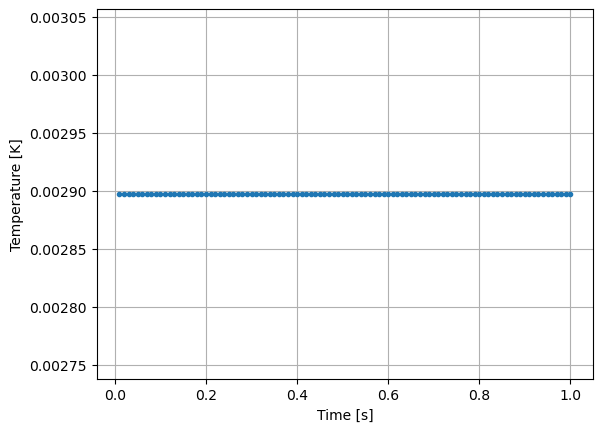

In [21]:
#Opgave 3

particles = []
temperatures = np.zeros(100, dtype=float)
times = np.linspace(1, 100, 100) * DT  # echte tijd in seconden (sim)

create_particles(particles)

for i in range(100):
    take_time_step_old(particles)
    # vastleggen van temperatuur per tijdstap
    temperatures[i] = temperature(particles)

plt.figure()
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.plot(times, temperatures, '-o', markersize=3)
plt.grid(True)
plt.show()


In [23]:
#Opgave 4
def temperature_sim_and_physical(particles):
    """
    Geeft zowel de 'ruwe' sim-grootheid <v^2> als de fysieke temperatuur in K.
    Dit laat zien hoe de factoren en eenheden in elkaar grijpen.
    """
    if len(particles) == 0:
        return 0.0, 0.0

    v2_sum = 0.0
    m = particles[0].m

    for p in particles:
        v2_sum += np.dot(p.v, p.v)

    v2_avg_sim = v2_sum / len(particles)

    v2_real = v2_avg_sim * (L_unit**2 / T_unit**2)
    m_real = m * M_unit
    T_real = m_real * v2_real / k_B

    return v2_avg_sim, T_real

# Voorbeeld: controle op één toestand
v2_avg_sim, T_real = temperature_sim_and_physical(particles)
print("Gemiddelde v^2 (sim):", v2_avg_sim)
print("Temperatuur (K):", T_real)


Gemiddelde v^2 (sim): 4.0
Temperatuur (K): 0.002897188206415968


In [25]:
impulse_outward = 0.0
pressure = 0.0
alpha = 1.0  # alpha = 1.0 betekent nog géén middeling (Exercise 5/6/7)


In [27]:
def top_down_collision(particle: ParticleClass):
    global impulse_outward
    if abs(particle.r[1]) + particle.R > BOX_SIZE_0 / 2:
        particle.r[1] = np.sign(particle.r[1]) * (BOX_SIZE_0/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * 2
        particle.v[1] *= -1


def left_right_collision(particle: ParticleClass):
    global impulse_outward
    if abs(particle.r[0]) + particle.R > BOX_SIZE_0 / 2:
        particle.r[0] = np.sign(particle.r[0]) * (BOX_SIZE_0/2 - particle.R)
        impulse_outward += abs(particle.momentum[0]) * 2
        particle.v[0] *= -1


def handle_walls(particles):
    """
    Botsingen met wanden controleren voor alle deeltjes in lijst
    en bepaling van de (gemiddelde) druk met exponentieel voortschrijdend gemiddelde.
    """
    global pressure, impulse_outward, alpha

    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)

    # 2D: omtrek van het vierkant = 4 * BOX_SIZE_0
    P_instant = impulse_outward / (4 * BOX_SIZE_0 * DT)

    # Exponentieel voortschrijdend gemiddelde (Exercise 7/8):
    # P_i = alpha * P + (1 - alpha) * P_{i-1}
    pressure = alpha * P_instant + (1 - alpha) * pressure


In [29]:
def take_time_step(particles):
    """Tijdstap met onderlinge botsingen én druk-berekening aan de wand."""
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)


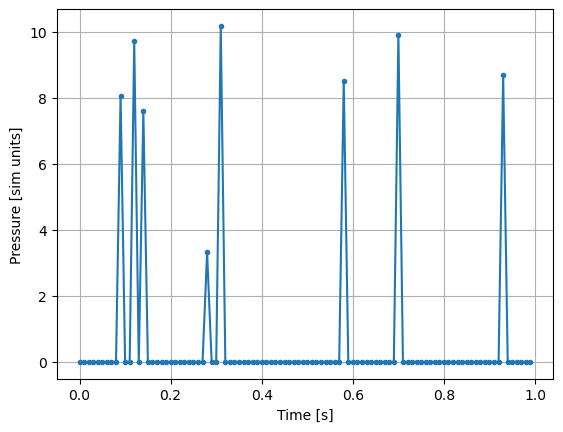

In [36]:
#Opgave 5
alpha = 1.0  # geen middeling, ruwe druk

particles = []
create_particles(particles)

n_steps = 100
pressures = np.zeros(n_steps)
times_P = np.arange(n_steps) * DT

pressure = 0.0  # reset globale druk

for i in range(n_steps):
    take_time_step(particles)
    pressures[i] = pressure

plt.figure()
plt.xlabel('Time [s]')
plt.ylabel('Pressure [sim units]')
plt.plot(times_P, pressures, '-o', markersize=3)
plt.grid(True)
plt.show()


### Uitleg Exercise 5

#De grafiek van de druk vertoont pieken en is niet mooi vlak, omdat druk in het model direct
#gekoppeld is aan momenten waarop deeltjes tegen de wand botsen. 

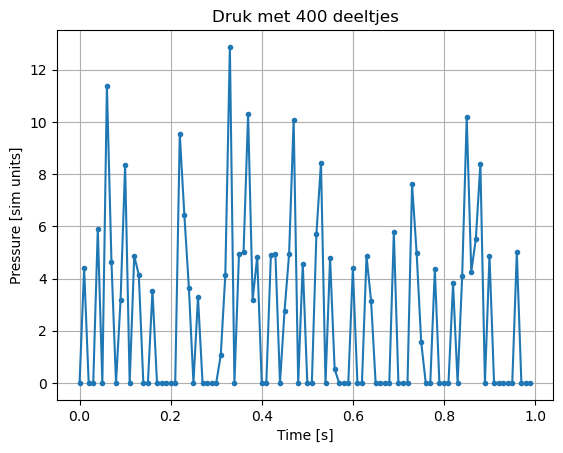

In [39]:
# Opgave 6
# Tijdelijk: N en BOX_SIZE_0 aanpassen
N_backup = N
BOX_backup = BOX_SIZE_0

N = 400
BOX_SIZE_0 = 20.0  # groter volume om te voorkomen dat het 'te vol' wordt

particles = []
create_particles(particles)

alpha = 1.0
pressure = 0.0

n_steps = 100
pressures_400 = np.zeros(n_steps)
times_400 = np.arange(n_steps) * DT

for i in range(n_steps):
    take_time_step(particles)
    pressures_400[i] = pressure

plt.figure()
plt.xlabel('Time [s]')
plt.ylabel('Pressure [sim units]')
plt.plot(times_400, pressures_400, '-o', markersize=3)
plt.grid(True)
plt.title('Druk met 400 deeltjes')
plt.show()

# Zet de initiële waarden weer terug
N = N_backup
BOX_SIZE_0 = BOX_backup

### Uitleg Exercise 6

#Met 400 deeltjes worden botsingen frequenter en wordt de drukgrafiek al wat "voller".
#Door het volume ook te vergroten blijft de dichtheid vergelijkbaar.



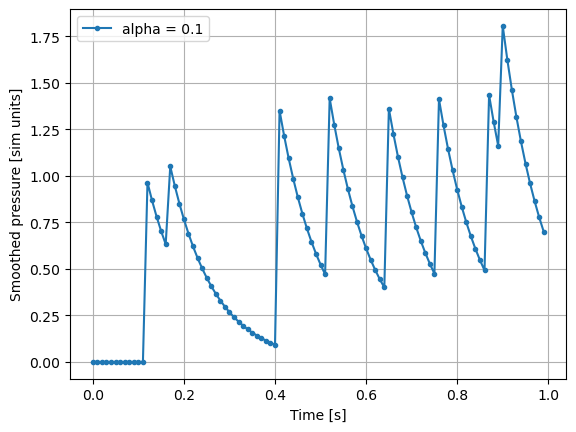

In [46]:
#Opgave 7
# Zelfde setup als bij Exercise 5, maar nu met alpha < 1
alpha = 0.1  # sterke middeling
pressure = 0.0

particles = []
create_particles(particles)

n_steps = 100
pressures_smoothed = np.zeros(n_steps)
times_s = np.arange(n_steps) * DT

for i in range(n_steps):
    take_time_step(particles)
    pressures_smoothed[i] = pressure

plt.figure()
plt.xlabel('Time [s]')
plt.ylabel('Smoothed pressure [sim units]')
plt.plot(times_s, pressures_smoothed, '-o', markersize=3, label=f'alpha = {alpha}')
plt.grid(True)
plt.legend()
plt.show()


In [49]:
# ### Exercise 8 – Toelichting

# # Met de exponentiële middeling wordt de ruwe drukwaarde in elke tijdstap
# # vervangen door een combinatie van de actuele druk en de vorige gemiddelde druk:

#  \

#  \[
#  P_i = \\alpha P + (1 - \\alpha) P_{i-1}.
#  \\]



# # - **Kleine α** (bijvoorbeeld 0.01–0.1): sterke demping, maar de grafiek reageert
# #   traag op echte veranderingen in de druk.
# # - **Grote α** (bijvoorbeeld 0.5–1.0): weinig demping, wel snelle reactie, dichter bij het ruwe signaal.

# # Het gemiddelde niveau van de druk verandert niet, maar de variatie op korte tijdschalen wordt onderdrukt.


In [50]:
# ### Exercise 9 – Uitleg naam “exponentieel voortschrijdend gemiddelde”

# Schrijf je de eerste paar stappen van de recursievergelijking uit:

# - \\(P_1 = \\alpha P_1^{(inst)} + (1 - \\alpha) P_0\\)
# - \\(P_2 = \\alpha P_2^{(inst)} + (1 - \\alpha) P_1\\)

# en vul je daar steeds \\(P_{i-1}\\) opnieuw in, dan krijg je een gewogen som van
# alle eerdere ruwe drukwaardes, met gewichten

# \

# \[
# (1 - \\alpha)^k,
# \\]



# dus een geometrische (exponentiële) afname met de “ouderdom” van de meting.  
# Oudere gegevens krijgen een gewicht dat exponentieel kleiner wordt. Daarom heet dit
# een **exponentieel voortschrijdend gemiddelde**.


In [52]:
# ### Exercise 10 – Structuur ideale gaswet in 2D-drukformule

# We vonden

# \

# \[
# \\langle P \\rangle = \\frac{m N}{A} \\frac{\\langle v^2 \\rangle}{2}.
# \\]



# Gebruik je de relatie tussen temperatuur en gemiddelde kinetische energie in 2D:

# \

# \[
# k_B T = m \\langle v^2 \\rangle,
# \\]



# dan kun je \\(\\langle v^2 \\rangle = k_B T / m\\) invullen en krijg je:

# \

# \[
# \\langle P \\rangle = \\frac{m N}{A} \\cdot \\frac{1}{2} \\cdot \\frac{k_B T}{m}
# = \\frac{N k_B T}{2 A}.
# \\]



# Dit lijkt sterk op de ideale gaswet \\(P V = N k_B T\\), maar dan aangepast
# aan de tweedimensionale situatie, waarbij het “volume” wordt vervangen door het oppervlak \\(A\\)
# en er een factor 1/2 optreedt vanwege het feit dat we in 2D werken en slechts twee vrijheidsgraden hebben.


In [53]:
# ### Exercise 11 – Reflectie

# In deze simulatie zien we duidelijk hoe macroscopische grootheden zoals temperatuur en druk
# ontstaan uit microscopische bewegingen van individuele deeltjes. De theorie voorspelt
# relaties als \\(k_B T = m \\langle v^2 \\rangle\\) en \\(\\langle P \\rangle \\propto N \\langle v^2 \\rangle / A\\),
# en de simulatie laat zien dat gemeten gemiddelde waarden rond deze theoretische verwachtingen schommelen.
# De ruis en fluctuaties zijn een direct gevolg van het eindige aantal deeltjes en de discretisering in de tijd.


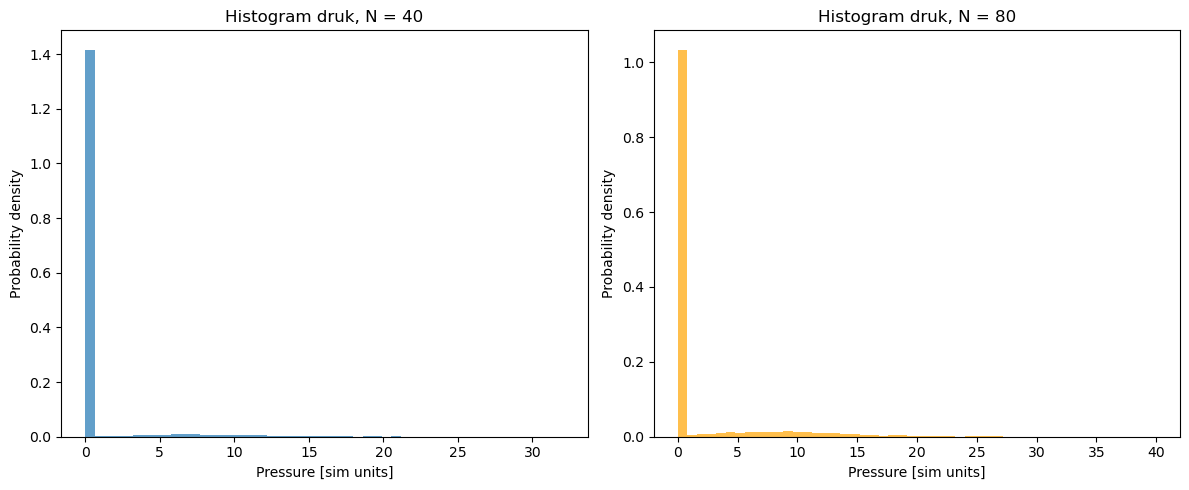

Standaarddeviatie druk, N = 40 : 3.0453387535359124
Standaarddeviatie druk, N = 80 : 4.365661488420403
Verhouding std_2N / std_N: 1.4335552927737438


In [55]:
#Opgave 12
def run_pressure_simulation(n_steps, n_particles, box_size, alpha_value=1.0):
    """
    Voert een simulatie uit en retourneert de reeks drukwaardes.
    """
    global N, BOX_SIZE_0, alpha, pressure

    N_backup = N
    BOX_backup = BOX_SIZE_0

    N = n_particles
    BOX_SIZE_0 = box_size
    alpha = alpha_value
    pressure = 0.0

    particles = []
    create_particles(particles)

    pressures_local = np.zeros(n_steps)

    for i in range(n_steps):
        take_time_step(particles)
        pressures_local[i] = pressure

    # Terugzetten
    N = N_backup
    BOX_SIZE_0 = BOX_backup

    return pressures_local


# Lange simulatie
n_steps_long = 10000
P_values_N = run_pressure_simulation(n_steps_long, n_particles=40, box_size=BOX_SIZE_0, alpha_value=1.0)
P_values_2N = run_pressure_simulation(n_steps_long, n_particles=80, box_size=BOX_SIZE_0, alpha_value=1.0)

# Histogrammen
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(P_values_N, bins=50, density=True, alpha=0.7)
plt.xlabel('Pressure [sim units]')
plt.ylabel('Probability density')
plt.title('Histogram druk, N = 40')

plt.subplot(1,2,2)
plt.hist(P_values_2N, bins=50, density=True, alpha=0.7, color='orange')
plt.xlabel('Pressure [sim units]')
plt.ylabel('Probability density')
plt.title('Histogram druk, N = 80')

plt.tight_layout()
plt.show()

# "Breedte" van de distributie, bijv. standaarddeviatie:
std_N = np.std(P_values_N)
std_2N = np.std(P_values_2N)

print("Standaarddeviatie druk, N = 40 :", std_N)
print("Standaarddeviatie druk, N = 80 :", std_2N)
print("Verhouding std_2N / std_N:", std_2N / std_N)
